In [18]:
%load_ext autoreload
%autoreload 2

import gstools as gs
import intake
import os
import zarr
import pandas as pd
import xarray as xr
import intake_esm
import numpy as np
from dask.distributed import Client
from cmip6_downscaling import CLIMATE_NORMAL_PERIOD
from cmip6_downscaling.constants import KELVIN, PERCENT, SEC_PER_DAY
import rioxarray
from rasterio.enums import Resampling
from cmip6_downscaling.workflows.share import (
    chunks,
    future_time,
    get_cmip_runs,
    hist_time,
    xy_region,
)
from cmip6_downscaling.workflows.utils import get_store
import matplotlib.pyplot as plt
intake_esm.__version__

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'2021.1.15'

In [19]:
import skdownscale

In [20]:
skdownscale.__file__

'/home/jovyan/scikit-downscale/skdownscale/__init__.py'

# access GCM data

will be replaced by `load_cmip_dictionary` and `gcm_munge`

In [21]:
from cmip6_downscaling.data.cmip import gcm_munge

In [22]:
activity_ids = ["CMIP", "ScenarioMIP"]
experiment_ids = ["historical", "ssp370"] #, "ssp126", "ssp245",  "ssp585"
member_ids = ["r1i1p1f1"]
source_ids = ["CanESM5"]#BCC-CSM2-MR"]
table_ids = ["day"]
grid_labels = ["gn"]
variables = 'tasmax'
variable_ids = [variables] #tasmax, tasmin, pr

In [23]:
col_url = "https://cmip6downscaling.blob.core.windows.net/cmip6/pangeo-cmip6.json"

col = intake.open_esm_datastore(col_url)
full_subset = col.search(
    activity_id=activity_ids,
    experiment_id=experiment_ids, 
    member_id=member_ids,
    table_id=table_ids,
    grid_label=grid_labels,
    variable_id=variable_ids,
    source_id=source_ids
)

In [24]:
gcm_ds_dict = full_subset.to_dataset_dict(
    zarr_kwargs={"consolidated": True, "decode_times": True, "use_cftime": True}, 
    storage_options={'account_name':'cmip6downscaling',
                     'account_key':os.environ.get('AccountKey', None)}
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [25]:
keys = gcm_ds_dict.keys()
historical_gcm = gcm_munge(gcm_ds_dict[[k for k in keys if 'historical' in k][0]])
future_gcm = gcm_munge(gcm_ds_dict[[k for k in keys if 'ssp' in k][0]])

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]
/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [26]:
historical_gcm

<xarray.Dataset>
Dimensions:  (lat: 64, lon: 128, time: 60225)
Coordinates:
  * lat      (lat) float64 87.86 85.1 82.31 79.53 ... -79.53 -82.31 -85.1 -87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * time     (time) object 1850-01-01 12:00:00 ... 2014-12-31 12:00:00
Data variables:
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(1879, 64, 128), meta=np.ndarray>
Attributes:
    CCCma_model_hash:            3dedf95315d603326fde4f5340dc0519d80d10c0
    CCCma_parent_runid:          rc3-pictrl
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-his01
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   1850:01:01:00
    YMDH_branch_time_in_parent:  5201:01:01:00
    activity_id:                 CMIP
    branch_method:               Spin-up documentation
    branch_time_in_child:        0.0
    branch_time_in_parent:       1223115.0
    cmor_version:                3.4.0
    contact:                     ec.cccma.info-info.ccmac.ec@canada.ca
    creation_date:               2019-05-02T08:02:01Z
    data_specs_version:          01.00.29
    experiment:                  all-forcing simulation of the recent past
    experiment_id:               historical
    external_variables:          areacella
    forcing_index:               1
    frequency:                   day
    further_info_url:            https://furtherinfo.es-doc.org/CMIP6.CCCma.C...
    grid:                        T63L49 native atmosphere, T63 Linear Gaussia...
    grid_label:                  gn
    history:                     2019-05-02T08:02:01Z ;rewrote data to be con...
    initialization_index:        1
    institution:                 Canadian Centre for Climate Modelling and An...
    institution_id:              CCCma
    license:                     CMIP6 model data produced by The Government ...
    mip_era:                     CMIP6
    netcdf_tracking_ids:         hdl:21.14100/7c67e43e-1378-466f-94fe-4aebc1e...
    nominal_resolution:          500 km
    parent_activity_id:          CMIP
    parent_experiment_id:        piControl
    parent_mip_era:              CMIP6
    parent_source_id:            CanESM5
    parent_time_units:           days since 1850-01-01 0:0:0.0
    parent_variant_label:        r1i1p1f1
    physics_index:               1
    product:                     model-output
    realization_index:           1
    realm:                       atmos
    references:                  Geophysical Model Development Special issue ...
    source:                      CanESM5 (2019): \naerosol: interactive\natmo...
    source_id:                   CanESM5
    source_type:                 AOGCM
    status:                      2020-07-06;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:              none
    sub_experiment_id:           none
    table_id:                    day
    table_info:                  Creation Date:(20 February 2019) MD5:374fbe5...
    title:                       CanESM5 output prepared for CMIP6
    tracking_id:                 hdl:21.14100/7c67e43e-1378-466f-94fe-4aebc1e...
    variable_id:                 tasmax
    variant_label:               r1i1p1f1
    version:                     v20190429
    version_id:                  v20190429
    intake_esm_varname:          ['tasmax']
    intake_esm_dataset_key:      CMIP.CCCma.CanESM5.historical.day.gn

In [27]:
future_gcm

<xarray.Dataset>
Dimensions:  (lat: 64, lon: 128, time: 31390)
Coordinates:
  * lat      (lat) float64 87.86 85.1 82.31 79.53 ... -79.53 -82.31 -85.1 -87.86
  * lon      (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * time     (time) object 2015-01-01 12:00:00 ... 2100-12-31 12:00:00
Data variables:
    tasmax   (time, lat, lon) float32 dask.array<chunksize=(1883, 64, 128), meta=np.ndarray>
Attributes:
    CCCma_model_hash:            1f91f92cb6d607391f44831504025d32fc44faa1
    CCCma_parent_runid:          rc3.1-his01
    CCCma_pycmor_hash:           33c30511acc319a98240633965a04ca99c26427e
    CCCma_runid:                 rc3.1-s7001
    Conventions:                 CF-1.7 CMIP-6.2
    YMDH_branch_time_in_child:   2015:01:01:00
    YMDH_branch_time_in_parent:  2015:01:01:00
    activity_id:                 ScenarioMIP AerChemMIP
    branch_method:               Spin-up documentation
    branch_time_in_child:        60225.0
    branch_time_in_parent:       60225.0
    cmor_version:                3.4.0
    contact:                     ec.cccma.info-info.ccmac.ec@canada.ca
    creation_date:               2019-05-02T08:46:38Z
    data_specs_version:          01.00.29
    experiment:                  gap-filling scenario reaching 7.0 based on SSP3
    experiment_id:               ssp370
    external_variables:          areacella
    forcing_index:               1
    frequency:                   day
    further_info_url:            https://furtherinfo.es-doc.org/CMIP6.CCCma.C...
    grid:                        T63L49 native atmosphere, T63 Linear Gaussia...
    grid_label:                  gn
    history:                     2019-05-02T08:46:38Z ;rewrote data to be con...
    initialization_index:        1
    institution:                 Canadian Centre for Climate Modelling and An...
    institution_id:              CCCma
    license:                     CMIP6 model data produced by The Government ...
    mip_era:                     CMIP6
    netcdf_tracking_ids:         hdl:21.14100/7a8900a2-b1dd-4c19-9a27-2e6b35a...
    nominal_resolution:          500 km
    parent_activity_id:          CMIP
    parent_experiment_id:        historical
    parent_mip_era:              CMIP6
    parent_source_id:            CanESM5
    parent_time_units:           days since 1850-01-01 0:0:0.0
    parent_variant_label:        r1i1p1f1
    physics_index:               1
    product:                     model-output
    realization_index:           1
    realm:                       atmos
    references:                  Geophysical Model Development Special issue ...
    source:                      CanESM5 (2019): \naerosol: interactive\natmo...
    source_id:                   CanESM5
    source_type:                 AOGCM
    status:                      2020-07-06;created; by gcs.cmip6.ldeo@gmail.com
    sub_experiment:              none
    sub_experiment_id:           none
    table_id:                    day
    table_info:                  Creation Date:(20 February 2019) MD5:374fbe5...
    title:                       CanESM5 output prepared for CMIP6
    tracking_id:                 hdl:21.14100/7a8900a2-b1dd-4c19-9a27-2e6b35a...
    variable_id:                 tasmax
    variant_label:               r1i1p1f1
    version:                     v20190429
    version_id:                  v20190429
    intake_esm_varname:          ['tasmax']
    intake_esm_dataset_key:      ScenarioMIP.CCCma.CanESM5.ssp370.day.gn

# access obs data

to be replaced by `open_era5`

In [28]:
# converts cmip standard names to ERA5 names
variable_name_dict = {
    'tasmax': 'air_temperature_at_2_metres_1hour_Maximum',
    'tasmin': 'air_temperature_at_2_metres_1hour_Minimum',
    'pr': 'precipitation_amount_1hour_Accumulation'
}

In [29]:
def get_store(bucket, prefix, account_key=None):
    ''' helper function to create a zarr store'''

    if account_key is None:
        account_key = os.environ.get('AccountKey', None)

    store = zarr.storage.ABSStore(
        bucket,
        prefix=prefix,
        account_name="cmip6downscaling",
        account_key=account_key
    )
    return store

def open_era5(var):
    col = intake.open_esm_datastore("https://cmip6downscaling.blob.core.windows.net/cmip6/ERA5_catalog.json")
    subset = col.search(variable=variable_name_dict[var], year=np.arange(2010, 2020))
    era5_stores = [store.split('az://cmip6/')[1] for store in subset.df.zstore.values]
    store_list = [get_store(bucket='cmip6', prefix=prefix) for prefix in era5_stores]
    ds = xr.open_mfdataset(store_list, engine='zarr', concat_dim='time').drop('time1_bounds')
    return ds

In [30]:
# full_obs = open_era5(variable)

In [31]:
# full_obs

# specify spatial regional subset and time periods

In [32]:
from cmip6_downscaling.data.cmip import convert_to_360

# parameters
historical_start = '2010'
historical_end = '2014'
future_start = '2015'
future_end = '2019'
min_lat = 19
max_lat = 55
min_lon = 227
max_lon = 299

# chunk shape for dask execution (time must be contiguous, ie -1)
chunks = {'lat': 10, 'lon': 10, 'time': -1}

In [33]:
# buffer = 3
# buffer_slice_lat = slice(max_lat + buffer, min_lat - buffer)
# buffer_slice_lon = slice(convert_to_360(min_lon) - buffer, convert_to_360(max_lon) + buffer)
# full_obs = full_obs.rio.write_crs('EPSG:4326')
# obs_buffer = full_obs.sel(lat=buffer_slice_lat, lon=buffer_slice_lon)
# obs_buffer = obs_buffer.resample(time='1D').reduce(np.max).rename({variable_name_dict[variable]:variable})
# obs_buffer = obs_buffer.chunk({'lat': 10, 'lon': 10, 'time': 1000})
# for v in obs_buffer:
#     print(v)
#     if 'chunks' in obs_buffer[v].encoding:
#         del obs_buffer[v].encoding['chunks']
# obs_buffer.to_zarr('obs_buffer.zarr', mode='w')

In [34]:
obs = xr.open_zarr('obs_buffer.zarr')
obs

,Array,Chunk
Bytes,772.72 MB,400.00 kB
Shape,"(3652, 169, 313)","(1000, 10, 10)"
Count,2177 Tasks,2176 Chunks
Type,float32,numpy.ndarray


# start of workflow

In [35]:
historical_period = slice(historical_start, historical_end)
future_period = slice(future_start, future_end)

In [36]:
from cmip6_downscaling.workflows.maca_flow import preprocess_maca

In [37]:
full_gcm, coarse_obs = preprocess_maca(
    historical_gcm=historical_gcm.sel(time=historical_period),
    future_gcm=future_gcm.sel(time=future_period),
    obs=obs, 
    min_lon=min_lon,
    max_lon=max_lon,
    min_lat=min_lat,
    max_lat=max_lat,
)

/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'lat_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(


using dimensions ('lat', 'lon') from data variable tasmax as the horizontal dimensions for this dataset.


/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:473: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [38]:
full_gcm.compute()

<xarray.Dataset>
Dimensions:      (lat: 13, lon: 26, time: 3650)
Coordinates:
  * lat          (lat) float64 54.42 51.63 48.84 46.04 ... 26.51 23.72 20.93
  * lon          (lon) float64 227.8 230.6 233.4 236.2 ... 292.5 295.3 298.1
  * time         (time) object 2010-01-01 12:00:00 ... 2019-12-31 12:00:00
    spatial_ref  int64 0
Data variables:
    tasmax       (time, lat, lon) float32 278.3 273.3 266.0 ... 300.2 300.2
Attributes:
    grid_mapping:  spatial_ref

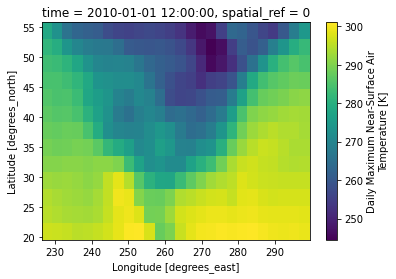

In [39]:
full_gcm.isel(time=0)[variables].plot()

In [40]:
coarse_obs.compute()

<xarray.Dataset>
Dimensions:      (lat: 13, lon: 26, time: 3652)
Coordinates:
    spatial_ref  int64 0
  * time         (time) datetime64[ns] 2010-01-01 2010-01-02 ... 2019-12-31
  * lon          (lon) float64 227.8 230.6 233.4 236.2 ... 292.5 295.3 298.1
  * lat          (lat) float64 54.42 51.63 48.84 46.04 ... 26.51 23.72 20.93
Data variables:
    tasmax       (time, lat, lon) float64 276.0 265.3 258.3 ... 299.2 299.3
Attributes:
    regrid_method:  bilinear

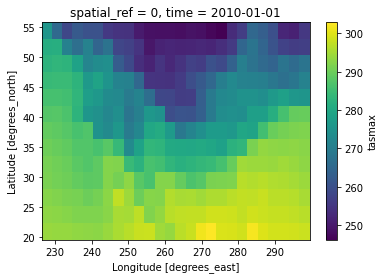

In [41]:
coarse_obs.isel(time=0)[variables].plot()

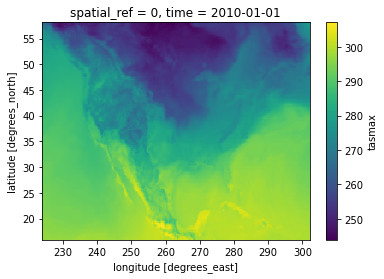

In [42]:
obs.isel(time=0)[variables].plot()

## Epoch Adjustment

In [43]:
from cmip6_downscaling.methods.detrend import epoch_adjustment

In [44]:
epoch_adjustment_kwargs = None
epoch_adjustment_kws = {'day_rolling_window': 21, 'year_rolling_window': 3}
epoch_adjustment_kws.update({} if not epoch_adjustment_kwargs else epoch_adjustment_kwargs)

# here, the time dimension of ea_gcm needs to be in 1 chunk 
ea_gcm, trend = epoch_adjustment(
    data=full_gcm, 
    historical_period=historical_period,
    **epoch_adjustment_kws
)

/srv/conda/envs/notebook/lib/python3.8/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing with an out-of-order index is generating 10 times more chunks
  return self.array[key]


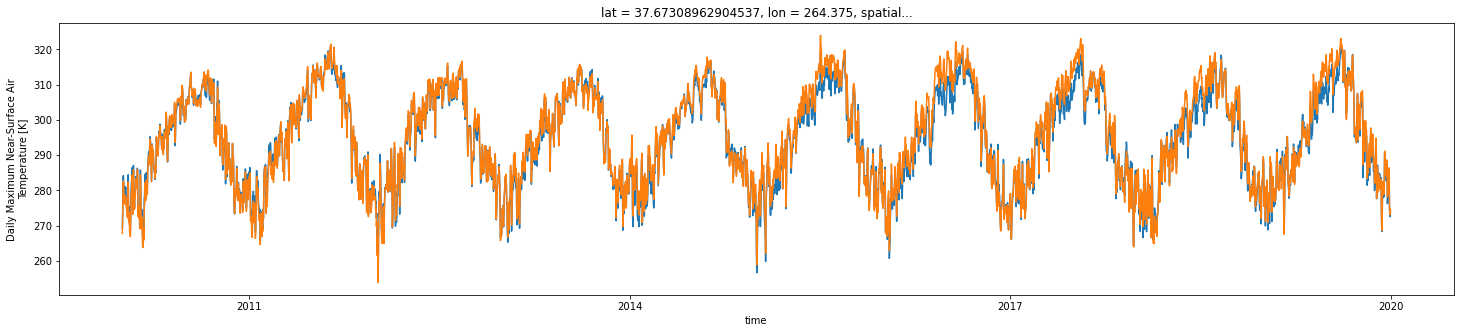

In [45]:
i = int(len(ea_gcm.lat) / 2)
j = int(len(ea_gcm.lon) / 2)
plt.figure(figsize=(25, 5))
ea_gcm.isel(lat=i, lon=j)[variables].plot(ax=plt.gca(), label='epoch adjusted')
full_gcm.isel(lat=i, lon=j)[variables].plot(ax=plt.gca(), label='original')

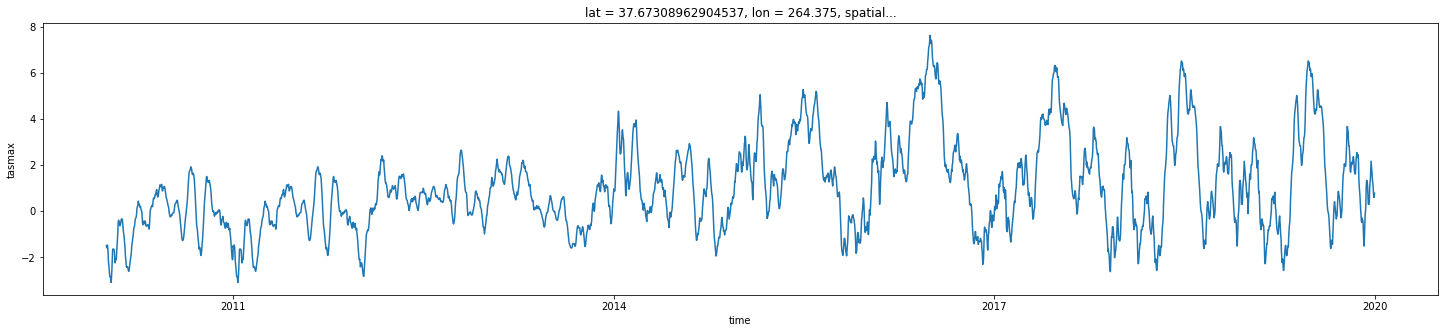

In [46]:
plt.figure(figsize=(25, 5))
trend.isel(lat=i, lon=j)[variables].plot(ax=plt.gca())

## coarse scale bias correction 

In [47]:
from cmip6_downscaling.workflows.maca_flow import maca_bias_correction

In [48]:
bias_correction_kwargs = None
bias_correction_kws = {'batch_size': 15, 'buffer_size': 15}
bias_correction_kws.update({} if not bias_correction_kwargs else bias_correction_kwargs)
bc_ea_gcm = maca_bias_correction(
    ds_gcm=ea_gcm,
    ds_obs=coarse_obs,
    historical_period=historical_period,
    variables=variables,
    **bias_correction_kws
)

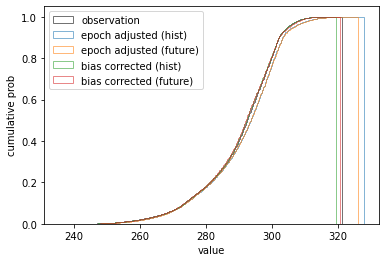

In [49]:
# plot cdf 
plt.hist(coarse_obs[variables].values.flatten(), bins=500, density=True, cumulative=True, label='observation', 
         histtype='step', alpha=0.55, color='k')

plt.hist(ea_gcm[variables].sel(time=historical_period).values.flatten(), label='epoch adjusted (hist)', 
         bins=500, density=True, cumulative=True, histtype='step', alpha=0.55)
plt.hist(ea_gcm[variables].sel(time=future_period).values.flatten(), label='epoch adjusted (future)', 
         bins=500, density=True, cumulative=True, histtype='step', alpha=0.55)

plt.hist(bc_ea_gcm[variables].sel(time=historical_period).values.flatten(), label='bias corrected (hist)', 
         bins=500, density=True, cumulative=True, histtype='step', alpha=0.55)
plt.hist(bc_ea_gcm[variables].sel(time=future_period).values.flatten(), label='bias corrected (future)', 
         bins=500, density=True, cumulative=True, histtype='step', alpha=0.55)

plt.legend(loc='upper left')
plt.xlabel('value')
plt.ylabel('cumulative prob')
plt.show()
plt.close()

## constructed analogs


In [50]:
from cmip6_downscaling.workflows.maca_flow import maca_constructed_analogs

In [66]:
X = coarse_obs.rename({'time': 'ndays_in_obs'})  # coarse obs 
y = bc_ea_gcm.rename({'time': 'ndays_in_gcm'})         # coarse gcm  

# get rmse between each GCM slices to be downscaled and each observation slices 
# will have the shape ndays_in_gcm x ndays_in_obs
rmse = np.sqrt(((X - y) ** 2).sum(dim=['lat', 'lon']))# / n_pixel_coarse

In [67]:
rmse

<xarray.Dataset>
Dimensions:       (ndays_in_gcm: 3650, ndays_in_obs: 3652)
Coordinates:
    spatial_ref   int64 0
  * ndays_in_obs  (ndays_in_obs) datetime64[ns] 2010-01-01 ... 2019-12-31
  * ndays_in_gcm  (ndays_in_gcm) object 2010-01-01 12:00:00 ... 2019-12-31 12...
    dayofyear     (ndays_in_gcm) int64 1 2 3 4 5 6 7 ... 360 361 362 363 364 365
Data variables:
    tasmax        (ndays_in_obs, ndays_in_gcm) float64 dask.array<chunksize=(1, 3650), meta=np.ndarray>

In [ ]:
# %debug
constructed_analogs_kwargs = None
constructed_analogs_kws = {'n_analogs': 10, 'doy_range': 45}
constructed_analogs_kws.update({} if not constructed_analogs_kwargs else constructed_analogs_kwargs)

downscaled_gcm = maca_constructed_analogs(
    ds_gcm=bc_ea_gcm[variables],
    ds_obs_coarse=coarse_obs[variables],
    ds_obs_fine=obs[variables],
    **constructed_analogs_kws
)

/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'lon_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/cf_xarray/accessor.py:1043: UserWarning: Variables {'lat_bnds'} not found in object but are referred to in the CF attributes.
  warnings.warn(
/srv/conda/envs/notebook/lib/python3.8/site-packages/dask/array/core.py:381: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  o = func(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(
/srv/conda/envs/notebook/lib/python3.8/site-packages/xesmf/frontend.py:439: FutureWarning: ``output_sizes`` should be given i

In [ ]:
downscaled_gcm.isel(time=slice(0, 10)).plot(col='time', col_wrap=5)

## epoch replacement

In [ ]:
from cmip6_downscaling.workflows.maca_flow import maca_epoch_replacement

In [ ]:
downscaled_bc_gcm = maca_epoch_replacement(
    ds_gcm_fine=downscaled_gcm,
    trend_coarse=trend,
)

In [ ]:
downscaled_bc_gcm.isel(time=slice(0, 10)).plot(col='time', col_wrap=5)

## fine scale bias correction

In [ ]:
final_gcm = maca_bias_correction(
    ds_gcm=downscaled_bc_gcm,
    ds_obs=obs,
    historical_period=historical_period,
    variables=variables,
    **bias_correction_kws
)